In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [2]:
# read the test batches from files created by the Preprocessing_NN_Data notebook
def read_batches(filepath):
    batches = []
    number_read = -1
    while True:
        number_read += 1
        try:
            batch = pd.read_csv(filepath + '_' + str(number_read) + '.csv', index_col=0, parse_dates=True)
            batches.append(batch)
        except FileNotFoundError:
            break
    return batches
            
test_batches = read_batches('data/test/batch')

In [3]:
# convert the dataframes in train_batches to the correct input and output shape (and make it arrays)
def convert_to_keras_input(batches):
    input_batches = []
    output_batches = []
    for batch in batches:
        input_df = batch.iloc[:,1:]
        output_df = batch['cl_kadij_out']
        input_batches.append(input_df.as_matrix()[:,np.newaxis,:])
        output_batches.append(output_df.as_matrix())
    return (input_batches, output_batches)

(input_test_batches, output_test_batches) = convert_to_keras_input(test_batches)

In [4]:
# load the trained model from a file
model_filename = 'models/2layer_lstm_11cells'

model = keras.models.load_model(model_filename + '.h5')
info_file = open(model_filename + '_info.txt')
info = ''
for line in info_file:
    info += line
info_file.close()
print('------- info of read model --------\n')
print(info)

------- info of read model --------

number of epochs: 1000
number of cells per layer: 11

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 11)             1012      
_________________________________________________________________
lstm_2 (LSTM)                (None, 11)                1012      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
Total params: 2,036
Trainable params: 2,036
Non-trainable params: 0
_________________________________________________________________



In [5]:
# get the test results:
output_model = []
actual_value = []
output_model_last = []
actual_value_last = []
for i in range(0,len(test_batches)):
    batch_output = model.predict(input_test_batches[i], batch_size = len(input_test_batches[i]))
    batch_actual = output_test_batches[i]
    for j in range(0, len(batch_output)):
        output_model.append(batch_output[j].item())
        actual_value.append(batch_actual[j].item())
    output_model_last.append(batch_output[-1].item())
    actual_value_last.append(batch_actual[-1].item())

In [6]:
# load the scaler data from a file and define a function that retransforms the cl_kadij data to the actual values
scaler_data = pd.read_csv('data/scaler_data.csv', index_col=0)

def rescale_data(data,scaler_name):
    data_range = scaler_data.loc[scaler_name, 'data_range_']
    data_min = scaler_data.loc[scaler_name, 'data_min_']
    converted = np.array(data) * data_range + data_min
    return converted
    
def convert_cl_kadij_output(output):
    rescaled_output = rescale_data(output, 'cl_kadij_scaler')
    return np.exp(rescaled_output)

In [7]:
# rescale and transform data back to original values:
output_model_scaled = convert_cl_kadij_output(output_model)
actual_value_scaled = convert_cl_kadij_output(actual_value)
output_model_last_scaled = convert_cl_kadij_output(output_model_last)
actual_value_last_scaled = convert_cl_kadij_output(actual_value_last)

In [8]:
# define some functions to print analysis of test results
def print_MSE(predicted, actual):
    '''calculates the MSE and prints it, returns the MSE'''
    errors = np.abs(predicted - actual)
    squared_errors = errors**2
    MSE = np.average(squared_errors)
    print('MSE:', MSE)
    return MSE

def print_prediction_skill(predicted, actual, verbose=False):
    '''calculates the prediction skill compared to the basic prediction method of using the same value as yesterday
       the calculated prediction skill is printed and returned
       note that it calls the print_MSE function which will also print the MSE
       use verbose=True to also print the MSE of the basic prediction method'''
    MSE = print_MSE(predicted, actual)
    basic_errors = np.abs(actual[1:] - actual[:-1])
    basic_MSE = np.average(basic_errors**2)
    prediction_skill = 1 - MSE / basic_MSE
    if (verbose):
        print('MSE basic method:', basic_MSE)
    print('prediction skill:', prediction_skill)
    return prediction_skill

In [9]:
# print the analysis results for the test data
print('When analysing prediction on all test data:')
print_prediction_skill(output_model_scaled, actual_value_scaled, True)
print('When analysing prediction only on last value of each test batch:')
print_prediction_skill(output_model_last_scaled, actual_value_last_scaled, True);

When analysing prediction on all test data:
MSE: 1684.17406248
MSE basic method: 2930.8910415
prediction skill: 0.42537131588
When analysing prediction only on last value of each test batch:
MSE: 861.962791081
MSE basic method: 6867.53505007
prediction skill: 0.874487310979


batch size 82

When analysing each data point in this batch:
MSE: 377.636260151
MSE basic method: 45.5925925926
prediction skill: -7.28284242411

When analysing only the last data point in this batch:
prediction SE: 11.5824
basic prediction SE: 49.0
prediction skill based on this single point: 0.76362487248


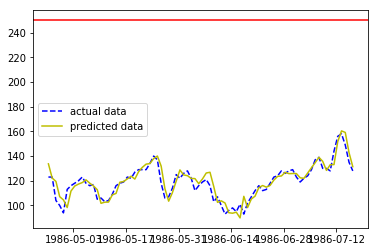

In [10]:
batch_index = 10
print('batch size', len(test_batches[batch_index]))
batch_output_model = model.predict(input_test_batches[batch_index], batch_size=len(input_test_batches[batch_index]))
batch_output_actual_converted = convert_cl_kadij_output(output_test_batches[batch_index])
batch_output_model_converted = convert_cl_kadij_output(batch_output_model)
plt.plot(test_batches[batch_index].index.values, batch_output_actual_converted, 'b--', label='actual data')
plt.plot(test_batches[batch_index].index.values, batch_output_model_converted, 'y', label='predicted data')
plt.axhline(250, color='red')
plt.legend();

print('\nWhen analysing each data point in this batch:')
print_prediction_skill(batch_output_model_converted, batch_output_actual_converted, True);
if (len(batch_output_actual_converted) >= 2):
    print('\nWhen analysing only the last data point in this batch:')
    prediction_SE = ((batch_output_model_converted[-1] - batch_output_actual_converted[-1])**2)[0]
    print('prediction SE:', prediction_SE)
    basic_SE = (batch_output_actual_converted[-1] - batch_output_actual_converted[-2])**2
    print('basic prediction SE:', basic_SE)
    print('prediction skill based on this single point:', 1 - prediction_SE / basic_SE)

In [11]:
# print the indices of big (>100) batches to use in the cell above
batch_sizes = [len(batch) for batch in test_batches]
print(np.where(np.array(batch_sizes) > 100))

(array([   7,   16,   19,   68,   72,   87,  101,  124,  142,  159,  174,
        177,  216,  218,  219,  251,  255,  257,  268,  314,  398,  418,
        426,  437,  449,  451,  470,  493,  498,  517,  524,  566,  581,
        585,  592,  624,  629,  642,  646,  648,  653,  676,  692,  696,
        718,  738,  742,  743,  756,  803,  812,  814,  815,  822,  825,
        829,  830,  841,  851,  865,  880,  894,  913,  918,  920,  928,
        936,  944, 1012, 1033, 1036, 1044, 1070, 1078, 1111, 1113, 1136,
       1147, 1161, 1184, 1186, 1190, 1246, 1249, 1303, 1318, 1319, 1324,
       1332, 1341, 1352, 1370, 1376], dtype=int64),)
